# ELG7186 - Winter 2022 - Assignment 2
## Due: <strong>Monday February 28<sup>th</sup> 2022 -- 11:59pm</strong>

The purpose of this assignment is to gain experience building and training neural networks. You will learn:
- Design and train a fully-connected neural network
- Train an existing CNN architecture using fine-tuning
- Visualize the trained model


### Submission Details
Submit your Jupyter notebook .ipynb file using Brightspace. Do not include any other files or images as they will not be reviewed.
<p>
<strong>Make certain that you run all the cells in the notebook you submit</strong> or you will loose marks.
</p>
<ul>
<li>You can submit multiple times, but only the most recent submission will be saved</li>
<li>Do not wait until the last minute to submit in case you have an unexpected issue</li>
<li>Review the late policy in the syllabus</li>
<li><strong>You must submit your own work</strong> and abide by the University of Ottawa policy on plagiarism and fraud</li>
</ul>


### DO NOT submit any images from the dataset

### Import Libraries

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.manifold import TSNE
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
import cv2
import os
import glob
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
from google.colab.patches import cv2_imshow
from mpl_toolkits.axes_grid1 import ImageGrid
drive.mount('/content/gdrive')
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import keras as K
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from numpy import expand_dims

Mounted at /content/gdrive


## Part 0. Data Preparation

To complete the assignment you will download the Caltech Bird dataset and devise an appropriate training set split. <b>You are free to sample from the dataset to reduce the overal training samples depending on your access to compute.</b> Again, the overall accuracy is less important than your  observations and comparisons.

Dataset: <a href="http://www.vision.caltech.edu/visipedia/CUB-200-2011.html">Caltech-UCSD Birds-200-2011</a> (Also posed on Brightspace)

The dataset contains annotations for various tasks. In this assignment you will use the categories for classification (species labels)

In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Create your splits for your dataset (there is a split provided for the full dataset) </li>
<li>Visualize five samples of each class by plotting a grid using the matplotlib library.</li>
</ul>


### Download the Dataset

In [4]:
def load_labels(path):
  labels = []
  with open(path, 'r') as f:
    for line in f:
      labels.append(int(line.split(' ')[1]))
  return labels

In [5]:
def load_class_names(path):
  cls_names = []
  with open(path, 'r') as f:
    for line in f:
      cls_names.append(line.split(' ')[1].rstrip("\n"))
  return cls_names

In [6]:
def load_image_pathts(path):
  img_names = []
  with open(path, 'r') as f:
    for line in f:
      img_names.append('/content/gdrive/MyDrive/dataset/images/' + line.split(' ')[1].rstrip("\n"))
  return img_names

In [7]:
def load_images(img_path, image_size):
    print('[INFO] Loading Images...')
    images = []
    for img in tqdm(img_path):
      image = cv2.imread(img)
      resized_image = cv2.resize(image, image_size, interpolation = cv2.INTER_AREA)
      images.append(resized_image)
    return images

In [8]:
images = load_images(load_image_pathts('/content/gdrive/MyDrive/dataset/images.txt'),(256,256))
labels = load_labels('/content/gdrive/MyDrive/dataset/image_class_labels.txt')
cls_names = load_class_names('/content/gdrive/MyDrive/dataset/classes.txt')
images = np.array(images)
labels = np.array(labels)

[INFO] Loading Images...


100%|██████████| 11788/11788 [2:07:23<00:00,  1.54it/s]


### split data into training and testing sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=0, shuffle=True)
print('X_train: '  + str(X_train.shape))
print('Y_train: '  + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (8841, 256, 256, 3)
Y_train: (8841,)
X_test:  (2947, 256, 256, 3)
Y_test:  (2947,)


### Visualize five samples of each class by plotting a grid

In [9]:
all_images = []
for i in range(1,201):
    index = np.where(labels==i)[0]
    pick = index[np.random.choice(index.shape[0], 5)]
    picked_images = images[pick]
    all_images.append(picked_images)

In [ ]:
def draw_func(list_of_imgs):
  fig = plt.figure(figsize=(16, 13))
  grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 5),  # creates 3x3 grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 )
  for ax, im in zip(grid, list_of_imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')

for i in tqdm(range(len(all_images))):
  draw_func(all_images[i])  

## Part 1. Perceptron (3 Marks)
For this section you will implement a fully connected neural network (multi-layer perceptron). To do this you will need to perform the following steps:
- Resize the images to be no larger than 32x32.
- Use the sequential model API in keras to build your network using dense layers (consider performance impacts of fully connected layers)
- You must decide an appropriate number of neurons and layers.
- Print a summary of your model configuration. 


When your classifier is working:
- Plot a loss curve for training and test data
- Plot an accuracy curve for training and test data
- Provide a brief discussion of your results 


### Resize the images to be 32x32.

In [10]:
images_32 = [cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA) for img in images]
images_32 = np.array(images_32)

In [11]:
X_train_32, X_test_32, y_train_32, y_test_32 = train_test_split(images_32, labels, test_size=0.25, random_state=0, shuffle=True)
print('X_train: '  + str(X_train_32.shape))
print('Y_train: '  + str(y_train_32.shape))
print('X_test:  '  + str(X_test_32.shape))
print('Y_test:  '  + str(y_test_32.shape))

X_train: (8841, 32, 32, 3)
Y_train: (8841,)
X_test:  (2947, 32, 32, 3)
Y_test:  (2947,)


### Standardizing Image Pixels

In [12]:
datagen_32 = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
datagen_32.fit(X_train_32)
train_iterator_32 = datagen_32.flow(X_train_32, y_train_32, batch_size=128)
test_iterator_32 = datagen_32.flow(X_test_32, y_test_32, batch_size=128)

### Use the sequential model API in keras to build your network using dense layers

In [13]:
model = Sequential()
model.add(Flatten(input_shape= (32,32,3)))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.7))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.7))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(201, activation='softmax'))  # ranges from 1 : 200
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Print a summary of the model configuration

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 2048)              6293504   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                        

### Model Training

In [22]:
%%time
history = model.fit_generator(train_iterator_32,
                              steps_per_epoch=len(train_iterator_32),
                              epochs=100,
                              verbose=1,
                              validation_data= test_iterator_32)

Epoch 1/100
70/70 [==============================] - 5s 32ms/step - loss: 5.5371 - accuracy: 0.0045 - val_loss: 5.3140 - val_accuracy: 0.0075
Epoch 2/100
70/70 [==============================] - 2s 28ms/step - loss: 5.4824 - accuracy: 0.0045 - val_loss: 5.3071 - val_accuracy: 0.0064
Epoch 3/100
70/70 [==============================] - 2s 27ms/step - loss: 5.4417 - accuracy: 0.0051 - val_loss: 5.3084 - val_accuracy: 0.0068
Epoch 4/100
70/70 [==============================] - 2s 27ms/step - loss: 5.4146 - accuracy: 0.0045 - val_loss: 5.3098 - val_accuracy: 0.0075
Epoch 5/100
70/70 [==============================] - 2s 27ms/step - loss: 5.4014 - accuracy: 0.0054 - val_loss: 5.3083 - val_accuracy: 0.0068
Epoch 6/100
70/70 [==============================] - 2s 27ms/step - loss: 5.3751 - accuracy: 0.0057 - val_loss: 5.3080 - val_accuracy: 0.0044
Epoch 7/100
70/70 [==============================] - 2s 28ms/step - loss: 5.3579 - accuracy: 0.0063 - val_loss: 5.3088 - val_accuracy: 0.0081
Epoch 

### Plot a loss curve for training and test data

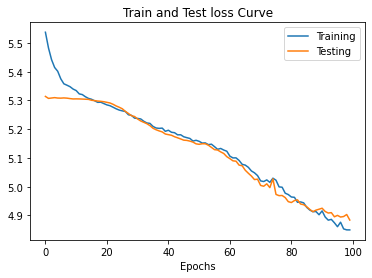

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test loss Curve')
plt.xlabel('Epochs');

### Plot an accuracy curve for training and test data

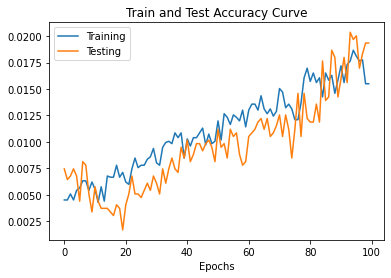

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test Accuracy Curve')
plt.xlabel('Epochs');

### Provide a brief discussion of your results

- we build a MLP (Fully connected layer) with 1 input, 8 hidden and 1 output layers.
- we used Relu activation function in all hidden layers and softmax for output layer.
- in the first few experiments our model overfits but we handled it by adding Dropout and BatchNormalization layers after each hidden layer.
- Training Accuracy: **0.0155** Testing Accuracy: **0.0193**.
- Training loss: **4.8498** and Testing loss: **4.8841**.
- as you can see from above hsitory, loss and accuracy curve, there is no overfit but the accuracy isn't good that's because we have a very big number of classes (200) and there is no enough images per class which the model can learn from them and dense layers is not the best architecture for image classification because it can't extract good features from the images and can't preserve the image semantic especially when you build it from scratch and don't have enough data to train the network.

## Part 2. VGG-16 (4 Marks)

For this section you will adapt the VGG-16 network for the current task using tranfer learning and fine-tuning. You will implement the following in your process:
- You should choose a suitable image size.
- Choose a suitable labelling scheme.
- Use the pretrained VGG16 network available in Keras.
- Remove the top fully connected layers. Include your own FC layers that match our dataset.
- Choose some layers to "freeze" and the remaining layers you will fine-tune with the new dataset.

### Step 1
You will use the above steps to train a VGG-16 model using the Bird dataset
- Use transfer learning to train your first model by removing the FC layers, but leaving the other layers intact.
- Plot a loss curve for training and test data
- Plot an accuracy curve for training and test data

### Step 2
Now use the same steps as above, but this time unfreeze some convolutional layers and retrain the network. Again, plot your results.

### Step 3
Discuss the results of both methods from step 1 and step 2 while using plots and graphics to support your discussion.


### Step 1: VGG-16 (removing the FC layers, but leaving the other layers intact)

### Resize the images to be 64x64.

In [52]:
images_64 = [cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA) for img in images]
images_64 = np.array(images_64)

In [53]:
X_train_64, X_test_64, y_train_64, y_test_64 = train_test_split(images_64, labels, test_size=0.25, random_state=0, shuffle=True)
print('X_train: '  + str(X_train_64.shape))
print('Y_train: '  + str(y_train_64.shape))
print('X_test:  '  + str(X_test_64.shape))
print('Y_test:  '  + str(y_test_64.shape))

X_train: (8841, 64, 64, 3)
Y_train: (8841,)
X_test:  (2947, 64, 64, 3)
Y_test:  (2947,)


### Standardizing Image Pixels

In [17]:
train_gen_64 = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input)
test_gen_64 = ImageDataGenerator(preprocessing_function=preprocess_input)

train_iterator_64 = train_gen_64.flow(X_train_64, y_train_64, batch_size=128) 
test_iterator_64 = test_gen_64.flow(X_test_64, y_test_64, batch_size=128)  

#### Load VGG-16 Model

In [18]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train_64[0].shape)
base_model.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


#### Print a summary of Vgg-16 model configuration

In [19]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

#### Add my own FC layers that match the dataset.

In [20]:
in_layer = Flatten()
layer_1 = Dense(4096, activation='relu')
layer_2 = Dense(1072, activation='relu')
out_layer = Dense(201, activation='softmax')

vgg_model = models.Sequential([
    base_model,
    in_layer,
    BatchNormalization(),
    layer_1,
    Dropout(0.5),
    BatchNormalization(),
    layer_2,
    Dropout(0.4),
    BatchNormalization(),
    out_layer
])

vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

#### Print a summary of Vgg-16 + Classification layer configuration

In [21]:
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_8 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 4096)              8392704   
                                                                 
 dropout_8 (Dropout)         (None, 4096)              0         
                                                                 
 batch_normalization_9 (Batc  (None, 4096)             16384     
 hNormalization)                                      

#### Training the Model

In [ ]:
%%time 
vgg_history = vgg_model.fit_generator(train_iterator_64,
                                      steps_per_epoch=len(train_iterator_64),
                                      epochs=100,
                                      verbose=1,
                                      validation_data= test_iterator_64,
                                      callbacks=[es])

Epoch 1/100
70/70 [==============================] - 23s 323ms/step - loss: 5.7451 - accuracy: 0.0138 - val_loss: 11.9113 - val_accuracy: 0.0224
Epoch 2/100
70/70 [==============================] - 21s 301ms/step - loss: 5.2804 - accuracy: 0.0276 - val_loss: 7.7262 - val_accuracy: 0.0373
Epoch 3/100
70/70 [==============================] - 22s 314ms/step - loss: 5.1233 - accuracy: 0.0366 - val_loss: 6.4735 - val_accuracy: 0.0553
Epoch 4/100
70/70 [==============================] - 22s 320ms/step - loss: 4.9706 - accuracy: 0.0430 - val_loss: 5.9053 - val_accuracy: 0.0563
Epoch 5/100
70/70 [==============================] - 21s 293ms/step - loss: 4.8425 - accuracy: 0.0454 - val_loss: 5.6707 - val_accuracy: 0.0624
Epoch 6/100
70/70 [==============================] - 21s 293ms/step - loss: 4.7453 - accuracy: 0.0485 - val_loss: 5.6451 - val_accuracy: 0.0628
Epoch 7/100
70/70 [==============================] - 20s 292ms/step - loss: 4.7390 - accuracy: 0.0533 - val_loss: 5.5010 - val_accuracy

### Plot a loss curve for training and test data

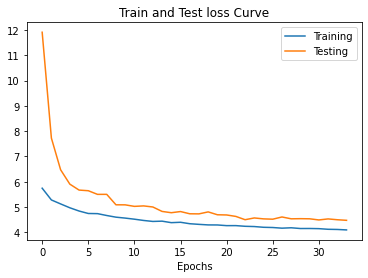

In [ ]:
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test loss Curve')
plt.xlabel('Epochs');

### Plot an accuracy curve for training and test data

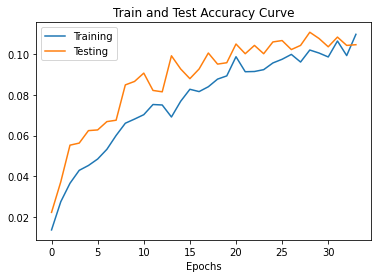

In [ ]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test Accuracy Curve')
plt.xlabel('Epochs');

### Step 2: Unfreeze some convolutional layers and retrain the network

#### Reset image data generators

In [22]:
train_iterator_64.reset()
test_iterator_64.reset()

#### Load the Vgg-16 Model and unfrozen the last 2 layers

In [23]:
vgg_model_ft = VGG16(weights="imagenet", include_top=False, input_shape=X_train_64[0].shape)
# I will unfrozen the last 2 layers for Fine-Tuning
for layer in vgg_model_ft.layers[:-2]:
  layer.trainable = False

#### Print a summary of fine tuned Vgg-16 model configuration

In [24]:
vgg_model_ft.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

#### Add my own FC layers that match the dataset to the fine tuned model.

In [25]:
in_layer = Flatten()
layer_1 = Dense(4096, activation='relu')
layer_2 = Dense(1072, activation='relu')
out_layer = Dense(201, activation='softmax')

vgg_model_fine = models.Sequential([
    vgg_model_ft,
    in_layer,
    Dropout(0.5),
    BatchNormalization(),
    layer_1,
    Dropout(0.5),
    BatchNormalization(),
    layer_2,
    Dropout(0.5),
    BatchNormalization(),
    out_layer
])

vgg_model_fine.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

#### Print a summary of Vgg-16 fine tuned + Classification layer configuration

In [26]:
vgg_model_fine.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 batch_normalization_11 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 4096)              8392704   
                                                                 
 dropout_11 (Dropout)        (None, 4096)              0         
                                                      

#### Training the Model

In [43]:
%%time 
vgg_history_ft = vgg_model_fine.fit_generator(train_iterator_64,
                                      steps_per_epoch=len(train_iterator_64),
                                      epochs=50,
                                      verbose=1,
                                      validation_data= test_iterator_64)

Epoch 1/50
70/70 [==============================] - 24s 344ms/step - loss: 4.0234 - accuracy: 0.1094 - val_loss: 4.1131 - val_accuracy: 0.1201
Epoch 2/50
70/70 [==============================] - 25s 352ms/step - loss: 4.0443 - accuracy: 0.1027 - val_loss: 4.1350 - val_accuracy: 0.1167
Epoch 3/50
70/70 [==============================] - 22s 314ms/step - loss: 4.0412 - accuracy: 0.1038 - val_loss: 4.0554 - val_accuracy: 0.1208
Epoch 4/50
70/70 [==============================] - 22s 319ms/step - loss: 4.0421 - accuracy: 0.1067 - val_loss: 4.1089 - val_accuracy: 0.1225
Epoch 5/50
70/70 [==============================] - 23s 327ms/step - loss: 3.9918 - accuracy: 0.1107 - val_loss: 4.0945 - val_accuracy: 0.1205
Epoch 6/50
70/70 [==============================] - 22s 319ms/step - loss: 3.9902 - accuracy: 0.1094 - val_loss: 4.0582 - val_accuracy: 0.1272
Epoch 7/50
70/70 [==============================] - 23s 322ms/step - loss: 4.0195 - accuracy: 0.1058 - val_loss: 4.0524 - val_accuracy: 0.1171

### Plot a loss curve for training and test data

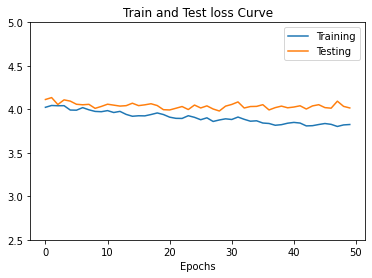

In [107]:
plt.plot(vgg_history_ft.history['loss'])
plt.plot(vgg_history_ft.history['val_loss'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test loss Curve')
plt.xlabel('Epochs')
plt.ylim(2.5,5);

### Plot an accuracy curve for training and test data

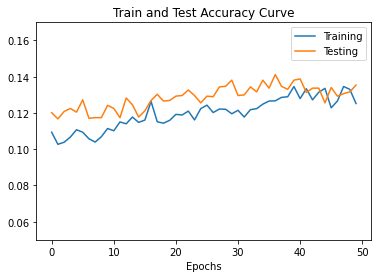

In [108]:
plt.plot(vgg_history_ft.history['accuracy'])
plt.plot(vgg_history_ft.history['val_accuracy'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test Accuracy Curve')
plt.xlabel('Epochs')
plt.ylim(0.05,0.17);

### Discussion of results in both methods from step 1 and step 2.

#### Step 1: Discussion

- firstly we resized our images to be 64x64 and standrized all images.
- we used the Vgg-16 as a Bootstrap Extractor, so we cut off the Fully-Connected layer (top) and integrate our customized one with the pre-trained layers also we freeze all pre-trained (non-trainable).
- we added Dropout, BatchNormalization and we also used early stopping callback to avoid overfit.
- the early stopping callback stop the training at epoch 34 with Training Accuracy: **0.1096** and Testing Accuracy: **0.1045** (no overfit).
- Training loss: **4.0955** and Testing loss: **4.4749**.
- here there was an improvement from the above step (MLP) **0.0193**.

#### Step 2: Discussion

- here at the Fine-Tuning approach, we to allow some of the pre-trained layers to retrain. so we cut off the Fully-Connected layer (top) and integrate our customized one with the pre-trained layers also we unfreeze the last 2 layers to be trainable for fine tunning.
- we allow for backpropagation to update the last two pre-trained layers.
- we added Dropout and BatchNormalization to avoid overfit.
- Training Accuracy: **0.1252** and Testing Accuracy: **0.1354** (no overfit).
- Training loss: **3.8255** and Testing loss: **4.0159**.
- here there was an improvement from the above (step1) **0.1096**.

#### Conclusion

- When you don't have a lot of data to work with, transfer learning might be a wonderful place to start when training a model.
- Transfer learning necessitates pre-training a model on a reliable source task that can be readily modified to handle a smaller target job.
- Model performance can be considerably improved by fine-tuning a subset of the pre-trained layers.

## Part 3. Visualization (3 Marks)

For this section you will visualize the filters learned byyour VGG-16 network and use t-SNE to observe clusters that were learned by your model.
- Make sure to provide the graphic results for your visualizations
- Provide an interpretation of the results

## Bonus (1 Mark)
Visualize the activation maps produced by your network and discuss the results using an image from the test test and another image of your choice.

####  visualize the filters learned by VGG-16 network

In [30]:
for layer in vgg_model_fine.layers:
	if 'conv' not in layer.name:
		continue
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


#### Visualize all filters of the first layer

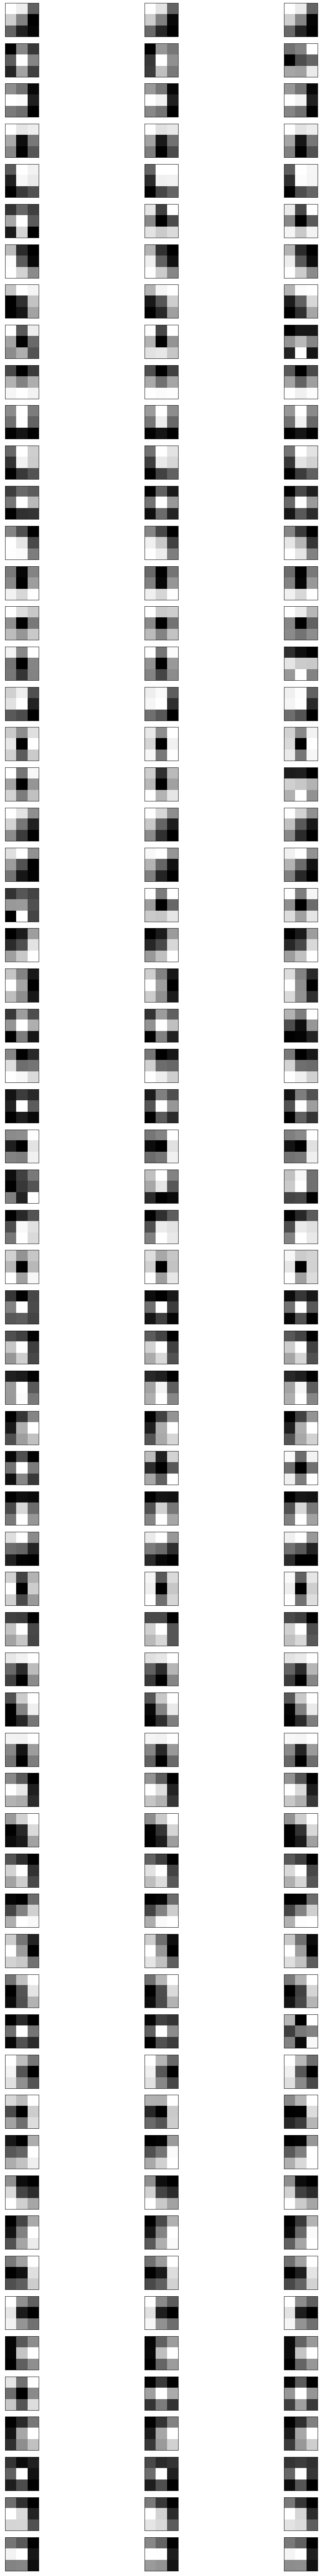

In [31]:
figure(figsize=(15, 100), dpi=80)
filters, biases = vgg_model_fine.layers[1].get_weights()
filter_min, filter_max = filters.min(), filters.max()
filters = (filters - filter_min) / (filter_max - filter_min)
# plot first 64 filters of each layer
no_filters, indx = 64, 1
for i in range(no_filters):
  f = filters[:, :, :, i]
  # plot each channel separately (R G B)
  for m in range(3):
    ax = plt.subplot(no_filters, 3, indx)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f[:, :, m], cmap='gray')
    indx += 1
plt.show()

#### visualize some filters of the first 9 layers execluding the pooling layers [3, 6, 10].

-----------------------------------------------Layer 2----------------------------------------------


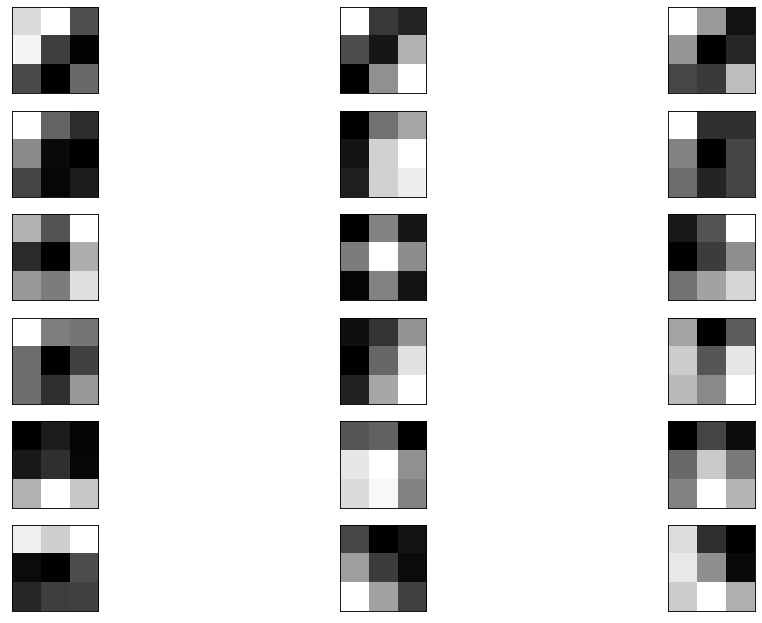

-----------------------------------------------Layer 4----------------------------------------------


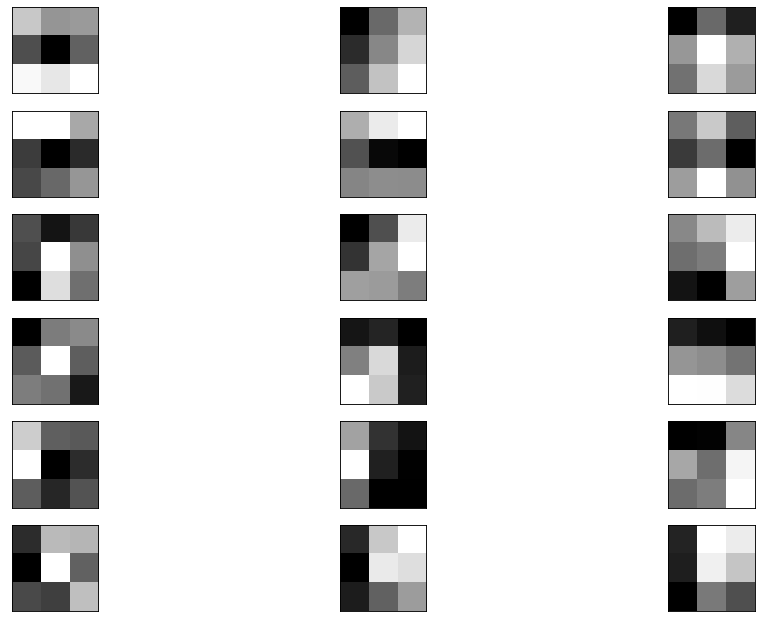

-----------------------------------------------Layer 5----------------------------------------------


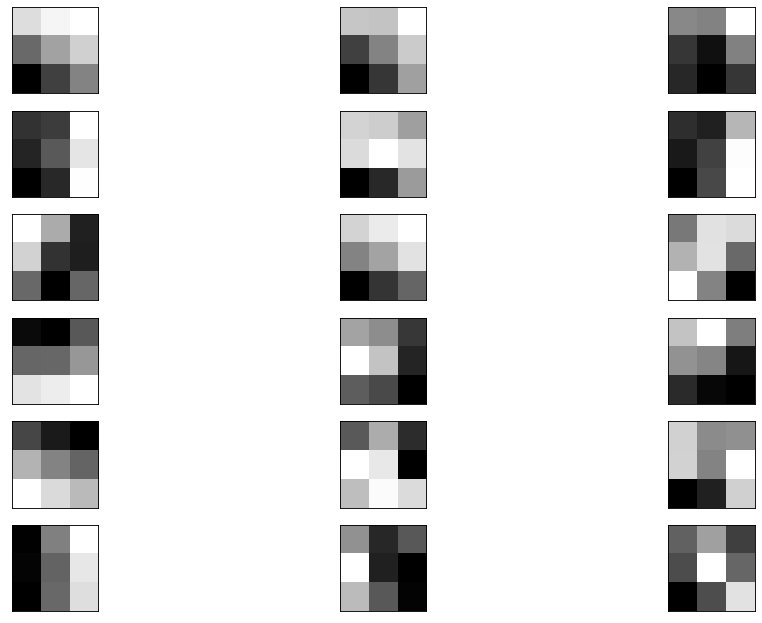

-----------------------------------------------Layer 7----------------------------------------------


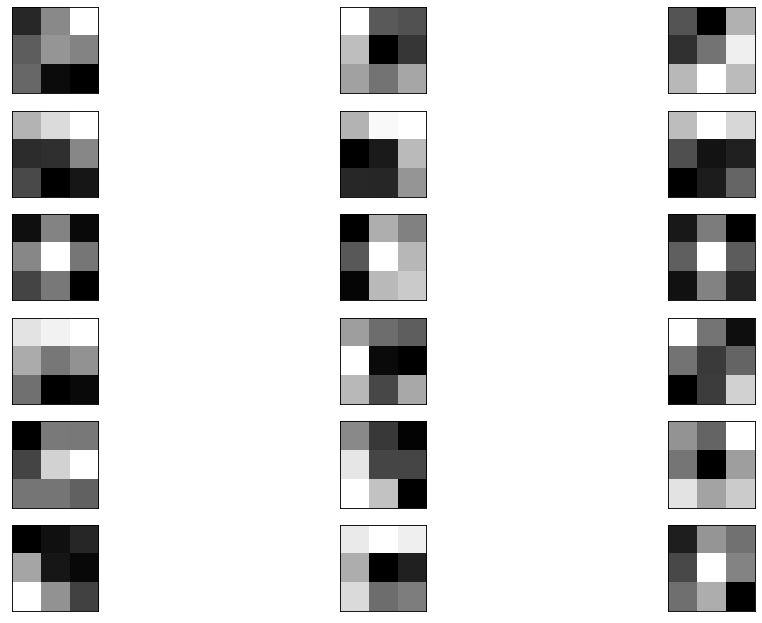

-----------------------------------------------Layer 8----------------------------------------------


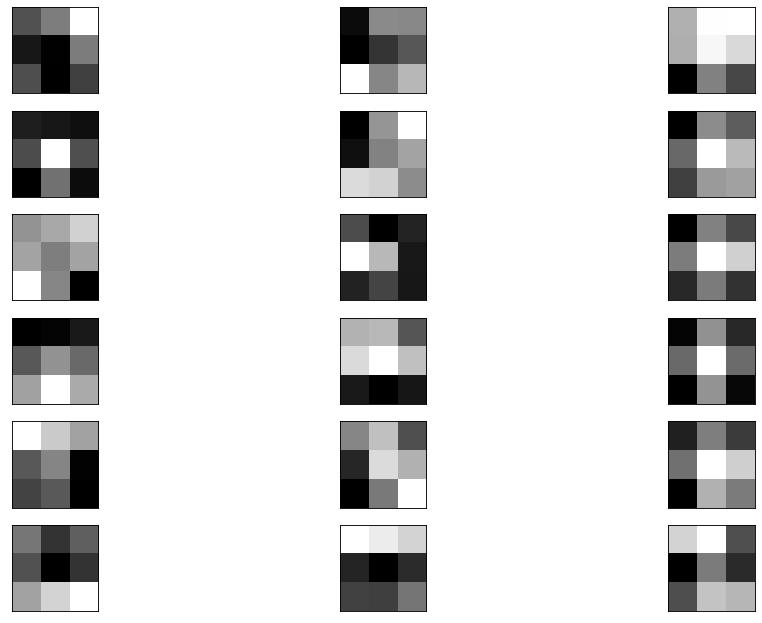

-----------------------------------------------Layer 9----------------------------------------------


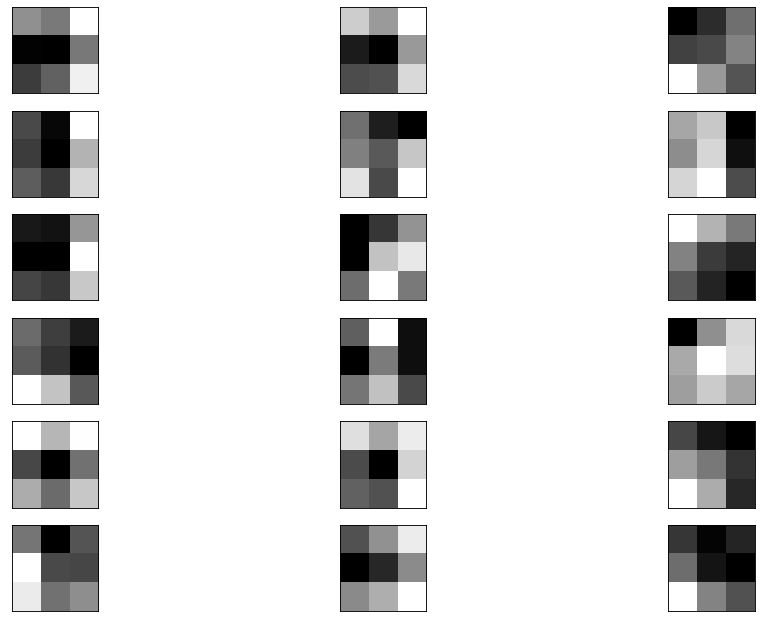

In [37]:
for i in [2,4,5,7,8,9]:
	print('-----------------------------------------------Layer {}----------------------------------------------'.format(i))
	figure(figsize=(15, 10), dpi=80)
	filters, biases = vgg_model_fine.layers[i].get_weights()
	filter_min, filter_max = filters.min(), filters.max()
	filters = (filters - filter_min) / (filter_max - filter_min)
	# plot first 6 filters of each layer
	no_filters, indx = 6, 1
	for i in range(no_filters):
		f = filters[:, :, :, i]
		# plot each channel separately (R G B)
		for m in range(3):
			ax = plt.subplot(no_filters, 3, indx)
			ax.set_xticks([])
			ax.set_yticks([])
			plt.imshow(f[:, :, m], cmap='gray')
			indx += 1
	plt.show()

#### Provide an interpretation of the results

- we visualized all filters (64) of the first layer then we visualized (6) filters of first 9 layers excluding the pooling layers [3, 6, 10].
- small or inhibitory weights are represented by dark squares, whereas big or excitatory weights are represented by bright squares.
- we can see that the filters on the first row of the first layer detect a gradient from light in the top left to dark in the bottom right.
- the filters on the third row of the first layer detect a gradient from light in the middle row to dark in right column and so on.


#### use t-SNE to observe clusters that were learned by the model

In [55]:
feature_ext = Model(inputs=vgg_model_fine.input, outputs=vgg_model_fine.layers[-1].output)
features = feature_ext.predict(X_test_64, batch_size=128)

In [56]:
tsne = TSNE().fit_transform(features)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

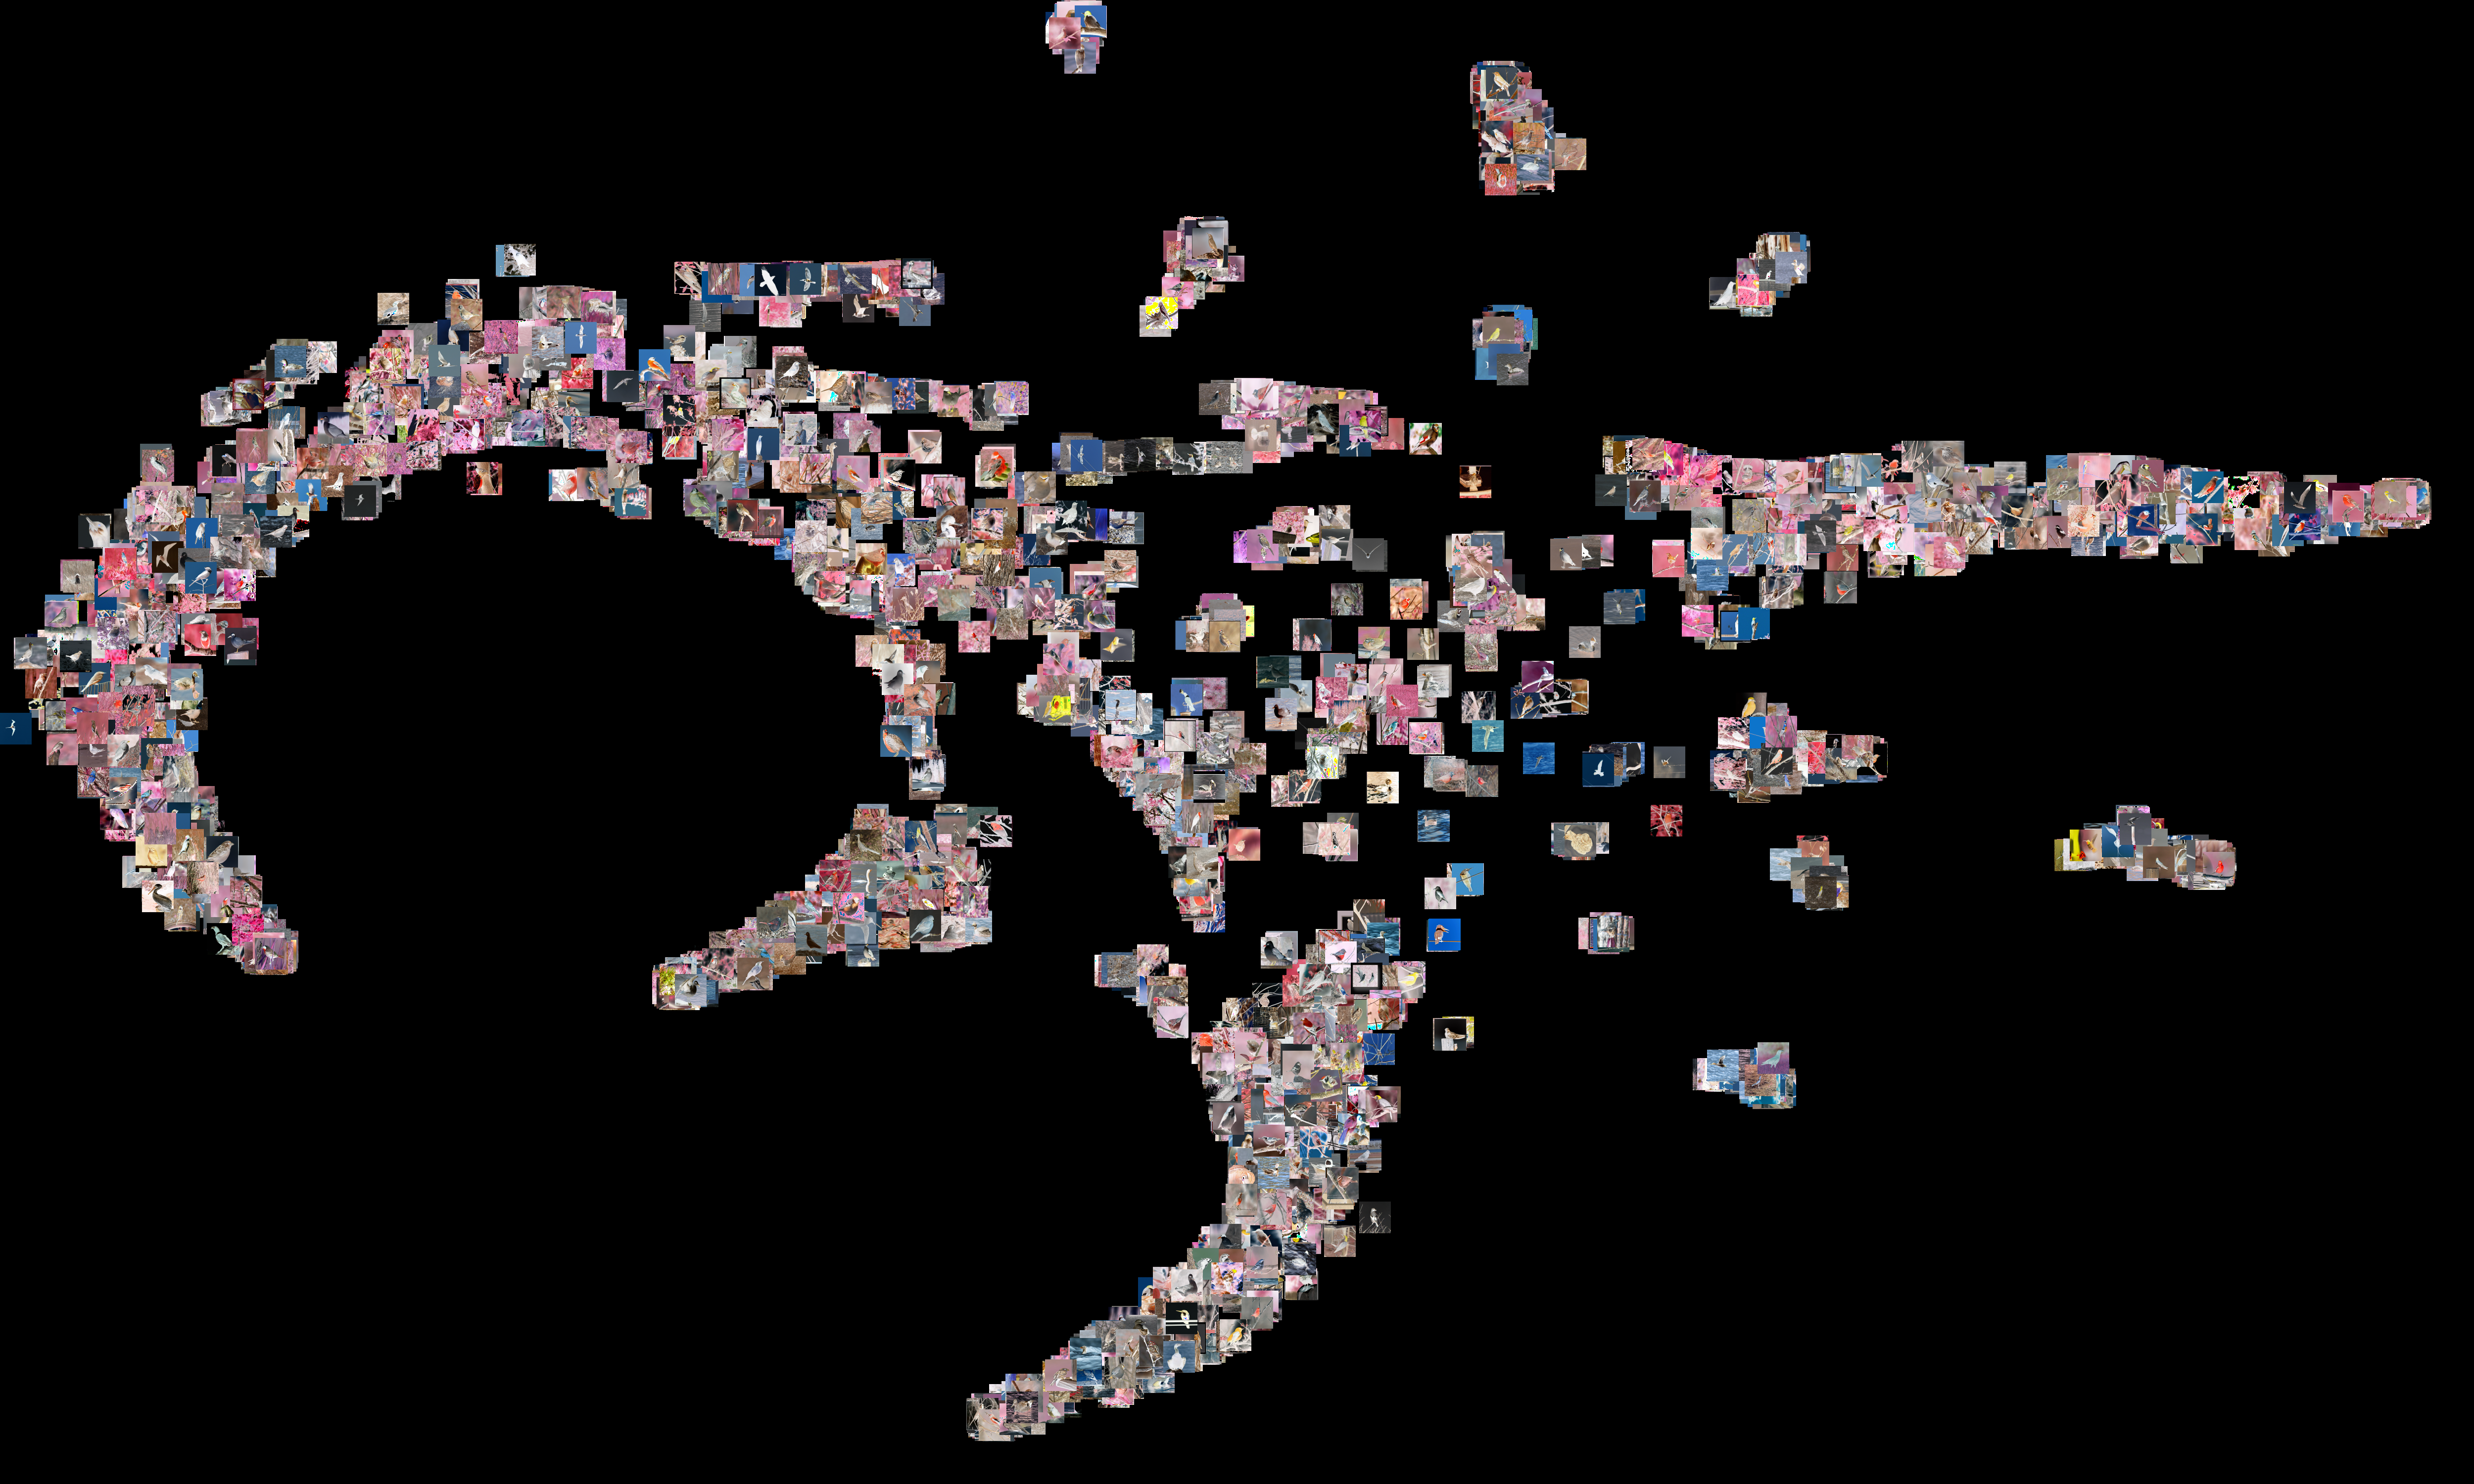

In [57]:
width = 5000
height = 3000
max_dim = 150
full_image = Image.new('RGB', (width, height))
for idx, x in enumerate(X_test_64):
    tile = Image.fromarray(np.uint8(x * 255))
    rs = max(1, tile.width / max_dim, tile.height / max_dim)
    tile = tile.resize((int(tile.width / rs),
                        int(tile.height / rs)),
                       Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim) * tx[idx]),
                            int((height-max_dim) * ty[idx])))
full_image

#### Provide an interpretation of the results

- before moving on to the classification process, we'll collect the test photos and run them through the network, saving the results. The activations from 'fc1' will be saved specifically.
- the altered numbers will then be normalised and plotted within a picture. The picture that generated each t-SNE coordinate will be stored in the positions of each t-SNE coordinate.
- the pixel-level information has been replaced with a representation that closely matches the image content in this new representation.
- The model has learned to separate these classes nicely in feature space, as evidenced by the t-SNE, Similar effects can also be noticed in birds classes.

#### Visualize the activation maps produced by your network

In [42]:
for i in range(len(vgg_model_fine.layers)):
	layer = vgg_model_fine.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 64, 64, 64)
2 block1_conv2 (None, 64, 64, 64)
4 block2_conv1 (None, 32, 32, 128)
5 block2_conv2 (None, 32, 32, 128)
7 block3_conv1 (None, 16, 16, 256)
8 block3_conv2 (None, 16, 16, 256)
9 block3_conv3 (None, 16, 16, 256)
11 block4_conv1 (None, 8, 8, 512)
12 block4_conv2 (None, 8, 8, 512)
13 block4_conv3 (None, 8, 8, 512)
15 block5_conv1 (None, 4, 4, 512)
16 block5_conv2 (None, 4, 4, 512)
17 block5_conv3 (None, 4, 4, 512)


#### discuss the results using an image from the test

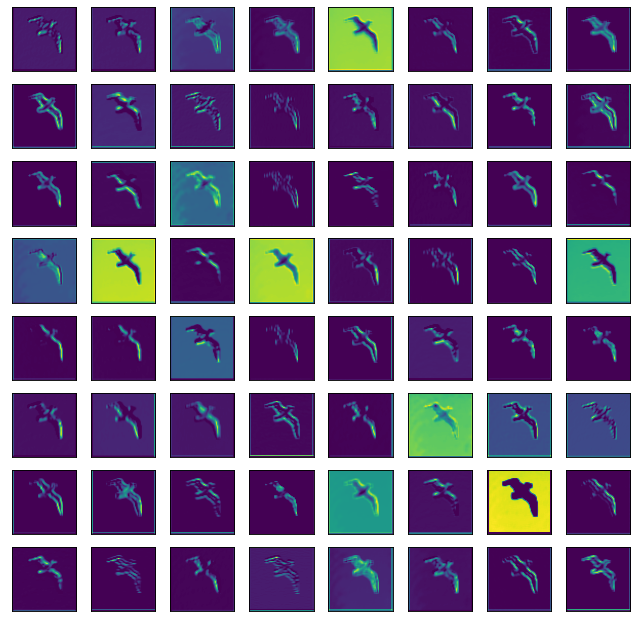

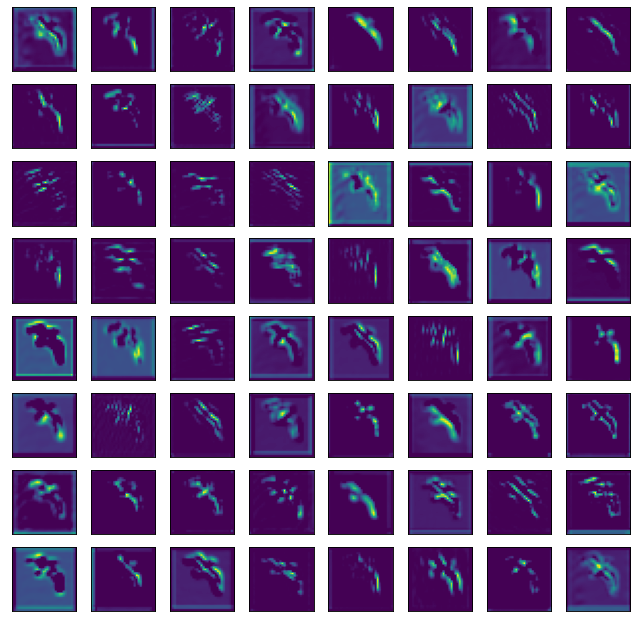

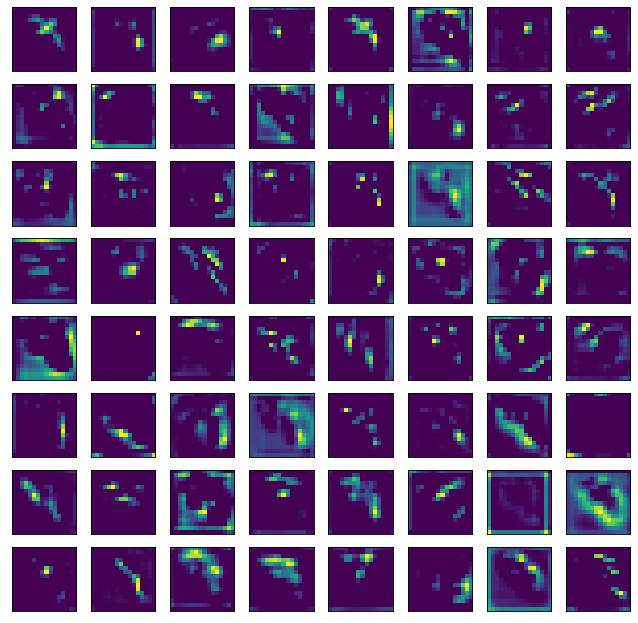

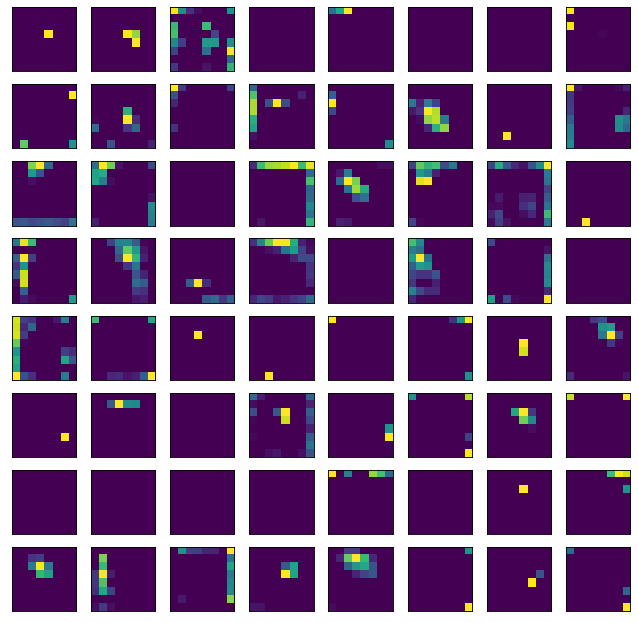

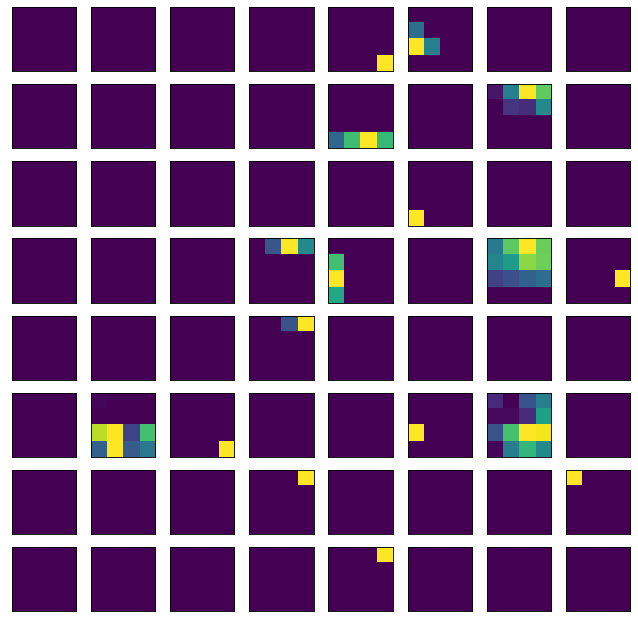

In [45]:
model = vgg_model_fine 
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
img = load_img('/content/gdrive/MyDrive/dataset/images/002.Laysan_Albatross/Laysan_Albatross_0073_927.jpg', target_size=(64, 64))
img = img_to_array(img)
img = expand_dims(img, axis=0)
img = preprocess_input(img)
feature_maps = model.predict(img)
square = 8
for fmap in feature_maps:
  ix = 1
  figure(figsize=(10, 10), dpi=80)
  for _ in range(square):
    for _ in range(square):
      ax = plt.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(fmap[0, :, :, ix-1])
      ix += 1
  plt.show()

#### discuss the results using image of your choice.

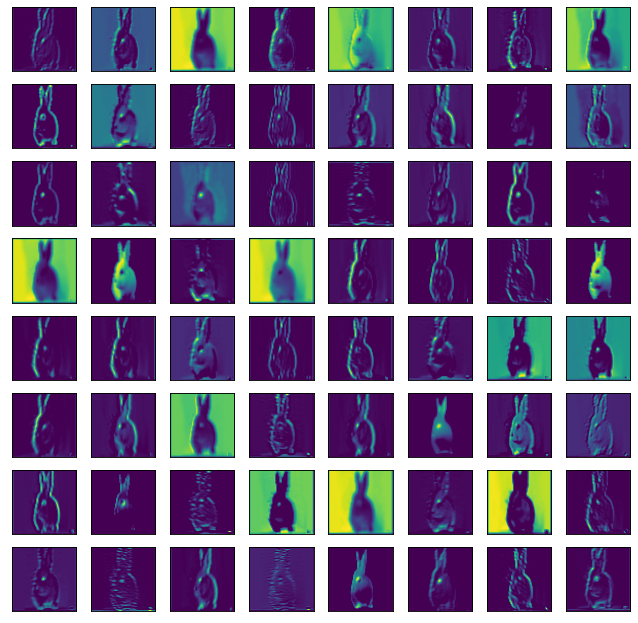

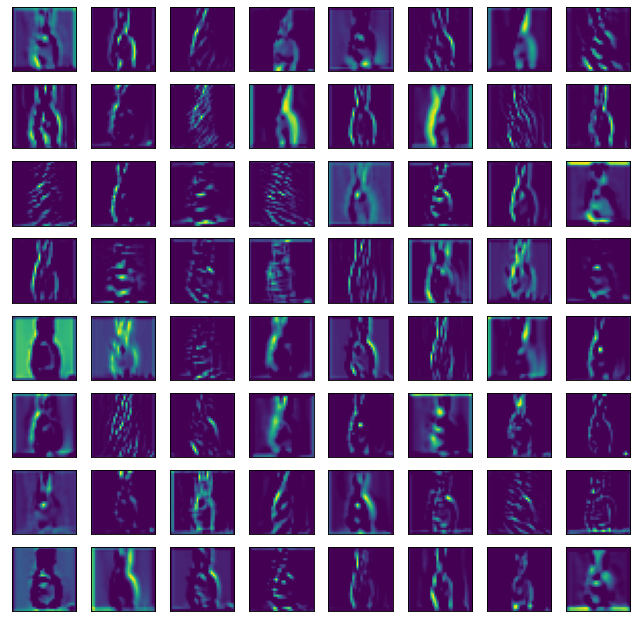

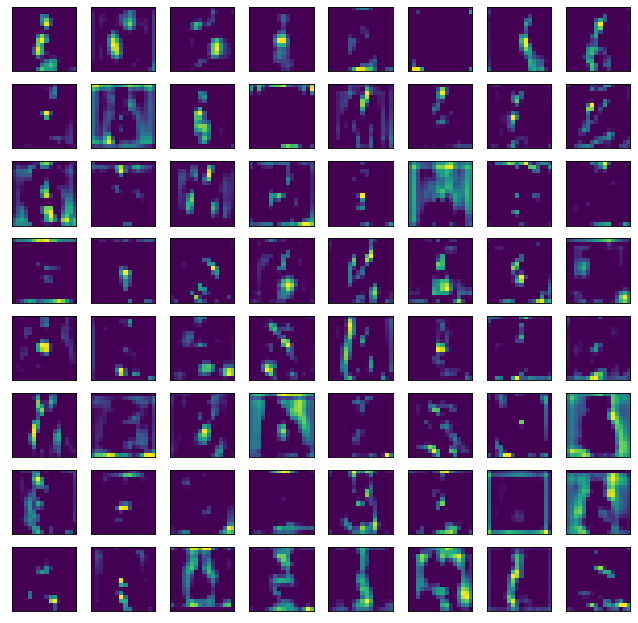

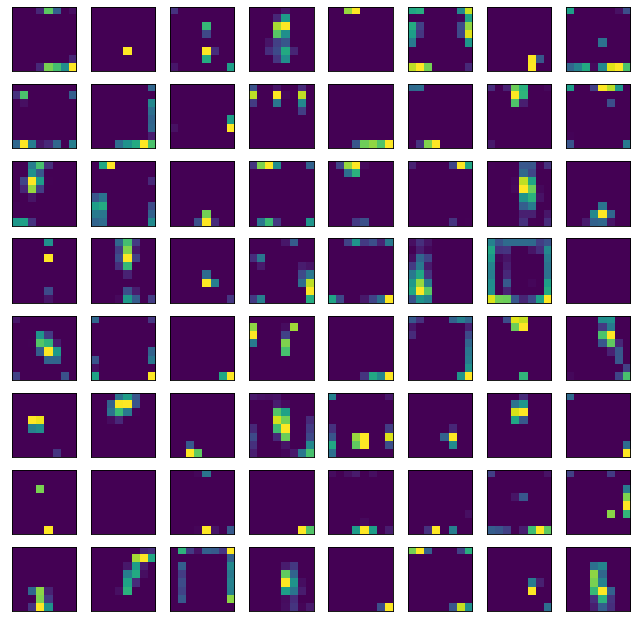

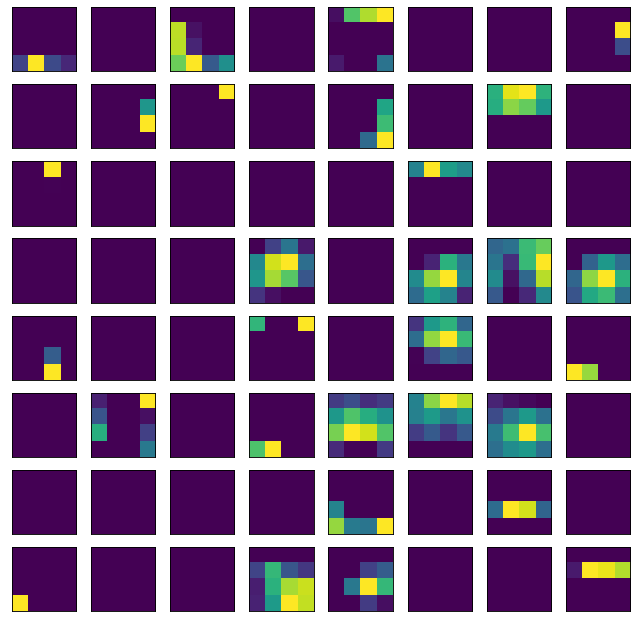

In [51]:
model = vgg_model_fine
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
img = load_img('/content/gdrive/MyDrive/dataset/image.jpg', target_size=(64, 64))
img = img_to_array(img)
img = expand_dims(img, axis=0)
img = preprocess_input(img)
feature_maps = model.predict(img)
square = 8
for fmap in feature_maps:
  ix = 1
  figure(figsize=(10, 10), dpi=80)
  for _ in range(square):
    for _ in range(square):
      ax = plt.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(fmap[0, :, :, ix-1])
      ix += 1
  plt.show()

#### Provide an interpretation of the results

- as we can observe that the feature maps near to the model's input capture a lot of fine detail in the image, whereas the feature maps display less and less detail as we go further into the model.
- the model abstracts the characteristics from the image into more broad ideas that may be used to create a classification, therefore this trend was predicted. Although it is unclear if the model spotted a bird in the final image, we often lose our ability to interpret these deeper feature maps.